In [2]:
!pip install kagglehub
!pip install streamlit tensorflow matplotlib scikit-learn

In [3]:
import kagglehub

# Download Intel Image Classification dataset
path = kagglehub.dataset_download("puneet6060/intel-image-classification")

print("Dataset path:", path)

Using Colab cache for faster access to the 'intel-image-classification' dataset.
Dataset path: /kaggle/input/intel-image-classification


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Class Distribution: {'seg_train': 6}


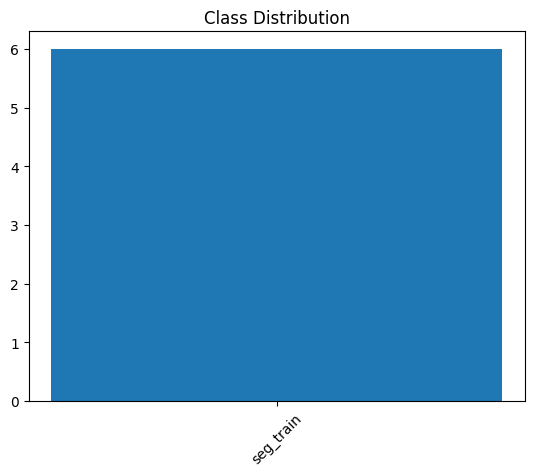

In [5]:
train_dir = os.path.join(path, "seg_train")

class_counts = {}
for cls in os.listdir(train_dir):
    class_counts[cls] = len(os.listdir(os.path.join(train_dir, cls)))

print("Class Distribution:", class_counts)

# Plot distribution
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=45)
plt.title("Class Distribution")
plt.show()

In [6]:
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='training'
)

val_data = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='validation'
)

test_data = ImageDataGenerator(rescale=1./255).flow_from_directory(
    os.path.join(path, "seg_test"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 11228 images belonging to 1 classes.
Found 2806 images belonging to 1 classes.
Found 3000 images belonging to 1 classes.


In [7]:
aug_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    shear_range=0.1,
    validation_split=0.2
)

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,126 (18.42 MB)

 Trainable params: 4,829,126 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# IMPORTANT: reset generator
test_data.reset()

# Use the model you trained
preds = model.predict(test_data)
y_pred = np.argmax(preds, axis=1)

print(classification_report(test_data.classes, y_pred))

cm = confusion_matrix(test_data.classes, y_pred)
print("Confusion Matrix:\n", cm)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 59s 618ms/step
              precision    recall  f1-score   support

           0       1.00      0.20      0.34      3000
           1       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0

    accuracy                           0.20      3000
   macro avg       0.20      0.04      0.07      3000
weighted avg       1.00      0.20      0.34      3000

Confusion Matrix:
 [[ 613 1393  110    1  883]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


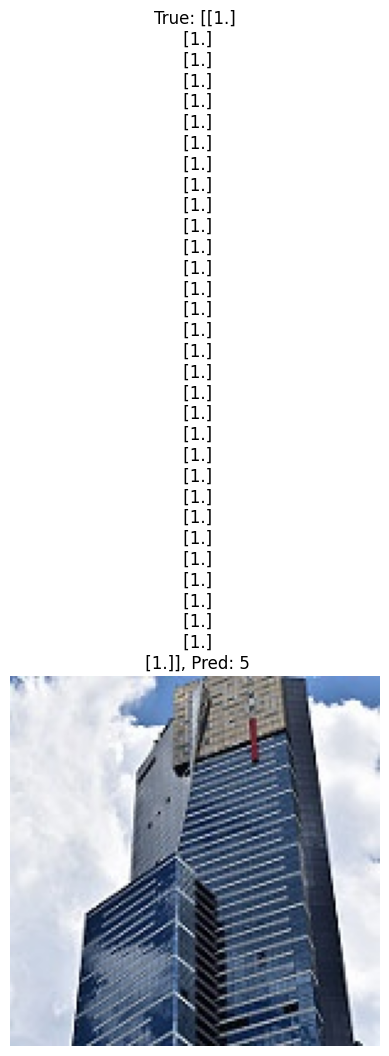

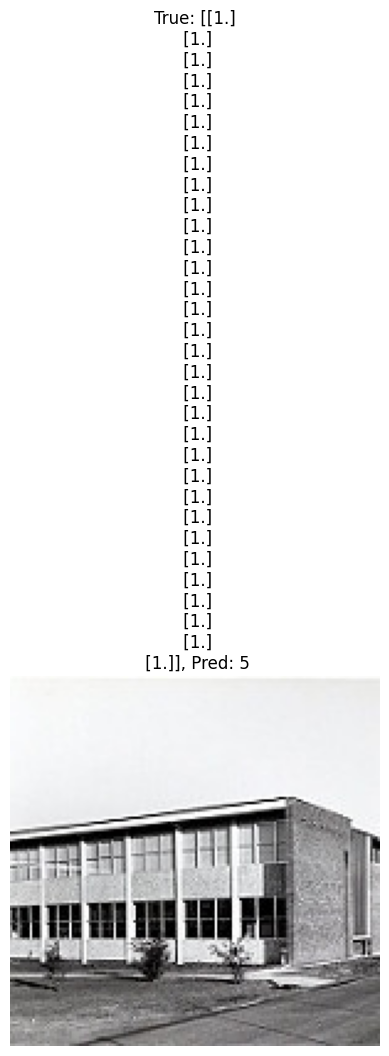

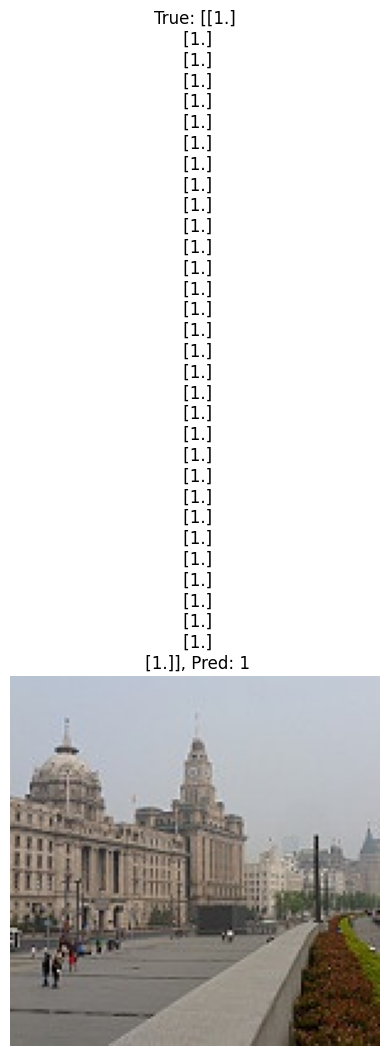

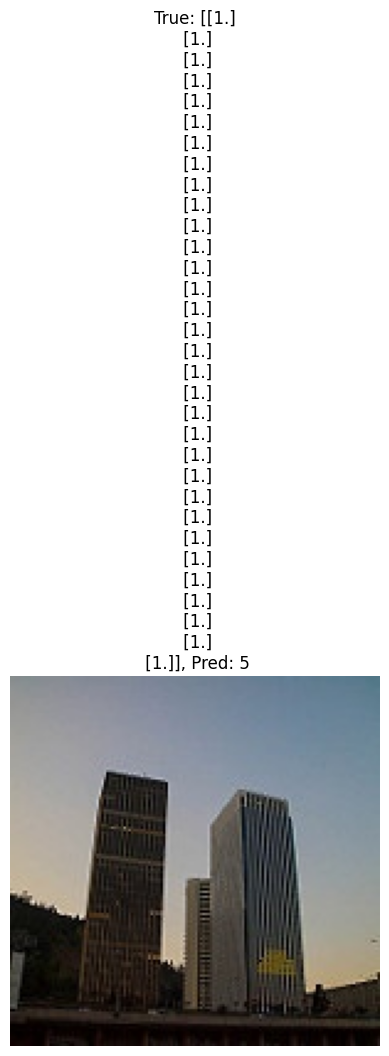

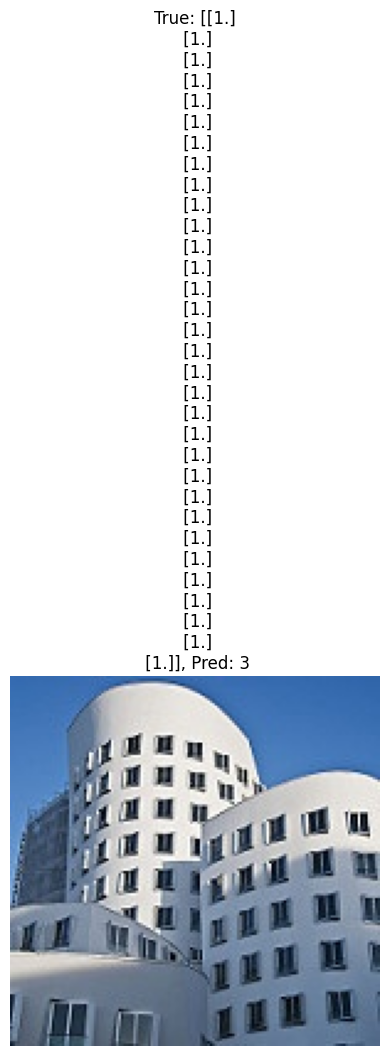

In [11]:
misclassified = np.where(y_pred != test_data.classes)[0]

for i in misclassified[:5]:
    img, label = test_data[i]
    plt.imshow(img[0])
    plt.title(f"True: {label}, Pred: {y_pred[i]}")
    plt.axis('off')
    plt.show()

In [12]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential

base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))

for layer in base.layers:
    layer.trainable = False

model_tl = Sequential([
    base,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

# ✅ FIXED LOSS
model_tl.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_tl = model_tl.fit(train_data, validation_data=val_data, epochs=5)

/tmp/ipython-input-1052245817.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 276s 769ms/step - accuracy: 0.9800 - loss: 0.0894 - val_accuracy: 1.0000 - val_loss: 4.6732e-10
Epoch 2/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 255s 726ms/step - accuracy: 1.0000 - loss: 6.9009e-07 - val_accuracy: 1.0000 - val_loss: 4.2484e-10
Epoch 3/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 252s 720ms/step - accuracy: 1.0000 - loss: 1.3684e-06 - val_accuracy: 1.0000 - val_loss: 3.3987e-10
Epoch 4/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 267s 760ms/step - accuracy: 1.0000 - loss: 1.3374e-06 - val_accuracy: 1.0000 - val_loss: 2.1242e-10
Epoch 5/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 271s 773ms/step - accuracy: 1.0000 - loss: 6.1379e-07 - val_accuracy: 1.0000 - val_loss: 1.6993e-10


In [15]:
model_tl.save("scene_model.h5")

In [17]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

base_model = MobileNetV2(weights='imagenet',
                         include_top=False,
                         input_shape=(224,224,3))

base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')   # ✅ FIXED
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])